# Exp 017: Corpus Grammar Description 
This experiment describes the used datasets in terms of the evaluation as the uncontrolled ground truth.

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ['CACHE_DIR'] = f"/scratch/tmp.{os.getenv('SLURM_JOB_ID')}.dglandorf" # speed up model loading

import sys
sys.path.append(f'../source')
import data
import helpers
import importlib
#importlib.reload(models)
#import evaluation
import models
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import DataParallel
import random
import seaborn as sns
from matplotlib import pyplot as plt
import pickle

random.seed(os.getenv("RANDOM_SEED"))

[nltk_data] Downloading package punkt to
[nltk_data]     /scratch/tmp.55153560.dglandorf...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
# params
out_file = '../data/corpus_classification_all.pkl'
dir="corpus_training"
max_responses = int(1e6)
n = 4
batch_size = 256
egp = helpers.get_egp()

Load dialogs and list of classifiers

In [4]:
dialog_data = data.get_dialog_data()
random.shuffle(dialog_data)
classifiers_nrs = helpers.get_existing_classifiers(dir)

Preprocess data

In [42]:
extracts = [[(dialog[0][i-n:i], dialog[0][i], dialog[1]) for i in range(n, len(dialog[0]))] for dialog in dialog_data]
extracts = helpers.flatten_list_of_lists(extracts)
extracts = extracts[0:max_responses]
sentences = [(idx, sentence) for idx, (context, response, source) in tqdm(enumerate(extracts), total=len(extracts)) for sentence in data.sent_tokenize(response)]
indices, sents = [s[0] for s in sentences], [s[1] for s in sentences]

  0%|          | 0/485600 [00:00<?, ?it/s]

## Run on corpus

In [66]:
encoded_inputs = models.bert_tokenizer(sents, return_tensors='pt', max_length=64, padding='max_length', truncation=True)
corpus_dataset = TensorDataset(encoded_inputs['input_ids'], encoded_inputs['attention_mask'])
corpus_dataloader = DataLoader(corpus_dataset, batch_size=batch_size, shuffle=False)

In [67]:
all_hit_indices = {}
all_hit_sentences = {}
for nr in classifiers_nrs:
    print(egp.iloc[nr-1]['Can-do statement'])
    classifier = models.load_classifier(nr, dir)
    classifier = DataParallel(classifier)
    scores, tokens = models.score_corpus(classifier, corpus_dataloader, max_positive=1e10, max_batches=1e5, threshold=0.5)
    results = list(zip(scores, sents))

    hit_indices = np.array(indices)[np.array(scores)>0.5]
    print("{:.2f}%".format(len(np.unique(hit_indices))/len(extracts)*100))
    
    hit_sentences = [sample for score, sample in results if score > 0.5]
    print(hit_sentences[0:20])
    
    all_hit_indices[nr] = hit_indices
    all_hit_sentences[nr] = hit_sentences

Can use the negative forms of mental process verbs ('I don't think', 'I don't believe') followed by a complement clause, where the negative form is in the mental process verb rather than the complement clause.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3270/3270 [13:27<00:00,  4.05it/s]


2.33%
["I don't know.", "I don't believe I have.", "I don't know why I am late all the time.", "Well, I don't know.", "I don't think they should be able to take dues from a republican worker and send it to a democrat campaign.", "Wow I didn't realize it's that old.", "You see, I already have more than 5, 000 RMB in my cash card, but I really don't know how much I should get.", "i don't recall many of he details.", "I didn't know that", "I don't know exact dates, but some say the sundae is actually a variation on the popular ice cream soda.", "batman is a character played by ben affleck, I don't know why it's called superman", "I don't doubt it!", "I can't say that I like her dislike her.", "And I didn't know that she was in the 1976 King Kong movie, I like the original King Kong movie, I'll have to check her eyes out", "Back to Meryl Streep, she actually has a daughter who plays the FBI agent on that show, I've seen that show but I don't remember her daughter, I'll have to check that o

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3270/3270 [13:34<00:00,  4.01it/s]


0.99%
["Say, why don't you come with us?", "it wasn't Disney or Universal?", "wasn't there like a short film that minions were in and all went from there?", "Who doesn't?", "I think they are a little bit expensive aren't they?", "That's amazing isn't it!", "Couldn't you do it today?", "and why isn't this hit done?", "The gallery's on Flower Street, isn't it?", "Didn't we have to show ID to get on the plane?", "More like what don't I like, lol.", "ya that is crazy, like why wouldn't the president always stay in the guest house then, do you know why the president of zimbabwe was nicknamed president banana?", "Isn't it cold there?", "Isn't it a cool scene when the arc reactor explodes and destroys Stane's armor?", "don't remember that... damn... why can't I remember so many scenes...", "Wouldn't that be funny if the place that fined him that late fee was Blockbuster?", "Isn't that wonderful?", "Why didn't you register then?", "Why don't you get it for me, and then I can call the police?",

In [76]:
with open(out_file, 'wb') as f:
    pickle.dump(all_hit_indices, f)
    pickle.dump(all_hit_sentences, f)
    pickle.dump(extracts, f)

# Analysis
Load data from script output

In [4]:
with open(out_file, 'rb') as f:
    all_hit_indices = pickle.load(f)
    all_hit_sentences = pickle.load(f)
    extracts = pickle.load(f)
responses = [e[1] for e in extracts]

/tmp/ipykernel_3238/3026258648.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x/len(extracts):.0%}' for x in plt.gca().get_xticks()])


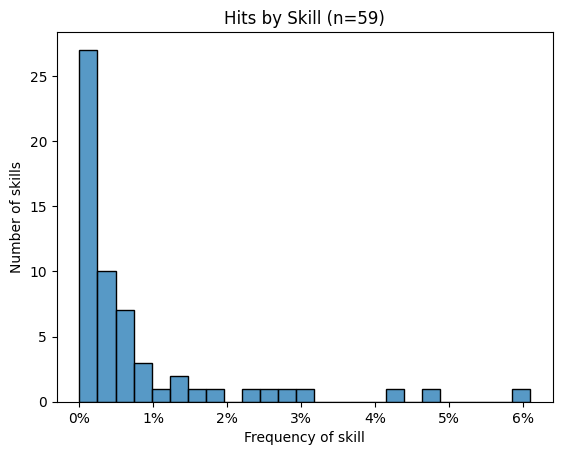

In [5]:
hit_ratios = np.array([len(np.unique(indices)) for indices in all_hit_indices.values()])
sns.histplot(hit_ratios, bins=25)
plt.gca().set_xticklabels([f'{x/len(extracts):.0%}' for x in plt.gca().get_xticks()])
plt.ylabel("Number of skills")
plt.xlabel("Frequency of skill")
plt.title(f"Hits by Skill (n={len(all_hit_indices):,})")
plt.show()

In [6]:
(hit_ratios<100).sum()

3

In [7]:
found_rules = np.array([set(nr for nr, indices in all_hit_indices.items() if index in indices) for index in tqdm(range(len(extracts)))])
found_statements = [{egp.iloc[nr-1]['Can-do statement'] for nr in rules} for rules in tqdm(found_rules)]
found_cats = [{egp.iloc[nr-1]['SubCategory'] for nr in rules} for rules in tqdm(found_rules)]
found_cat_level = [{f"{egp.iloc[nr-1]['SubCategory']}-{egp.iloc[nr-1]['Level']}" for nr in rules} for rules in tqdm(found_rules)]

num_rules = np.array([len(rules) for rules in found_rules])
num_cats = np.array([len(cats) for cats in found_cats])

  0%|          | 0/485600 [00:00<?, ?it/s]

  0%|          | 0/485600 [00:00<?, ?it/s]

  0%|          | 0/485600 [00:00<?, ?it/s]

  0%|          | 0/485600 [00:00<?, ?it/s]

In [115]:
list(zip([responses[int(i)] for i in np.nditer(np.where(num_cats>2))], np.array(found_cat_level)[num_cats>2]))[1:100]

[("I don't think too many people would agree with you.  Since they know it's out there and about them.  All those sites are supposed to self-police and ban people who are abusers and if they don't they should be taken off-line.",
  {'conditional-A2', 'negation-A1', 'negation-B1', 'would-A2'}),
 ("you're right. If she walked into meetings with our clients like that, it would make our company look bad, wouldn't it?",
  {'conditional-A2', 'conditional-B1', 'negation-B1', 'would-A2', 'would-B1'}),
 ("Exactly! I wouldn't want to have to listen to that type of stuff if I was a woman!",
  {'conditional-B1', 'negation-A2', 'would-A2', 'would-B1'}),
 ("there just isn't enough affordable housing to go around. If only the housing cost would drop, fewer people would be in financial trouble.",
  {'conditional-B1', 'negation-A1', 'would-A2', 'would-B1'}),
 ("Umm.. okay.. I was reading the document.  I was supposed to be allowed to read for 5 minutes.. before I actually ended up chatting.  I read.. a

/tmp/ipykernel_12851/3354633450.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x/len(extracts):.0%}' for x in plt.gca().get_yticks()])


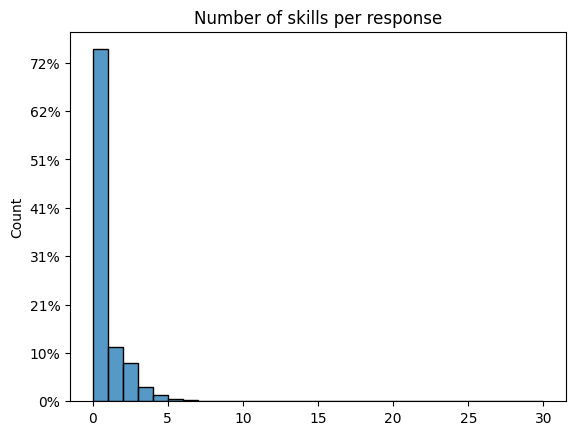

In [118]:
sns.histplot(num_rules, bins=max(num_rules))
plt.gca().set_yticklabels([f'{x/len(extracts):.0%}' for x in plt.gca().get_yticks()])

plt.title("Number of skills per response")
plt.show()

/tmp/ipykernel_12851/1149020872.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x/len(extracts):.0%}' for x in plt.gca().get_yticks()])


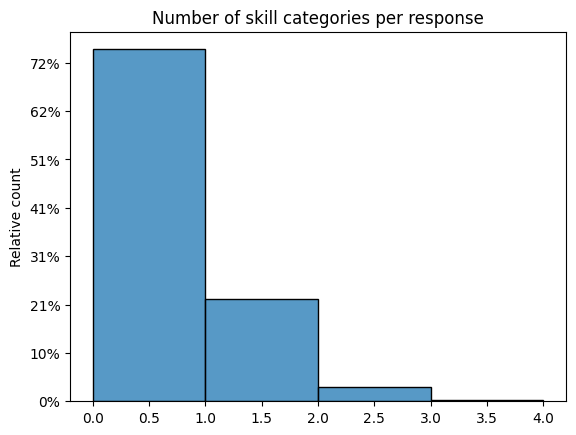

In [122]:
sns.histplot(num_cats, bins=max(num_cats))
plt.gca().set_yticklabels([f'{x/len(extracts):.0%}' for x in plt.gca().get_yticks()])
plt.title("Number of skill categories per response")
plt.ylabel("Relative count")
plt.show()

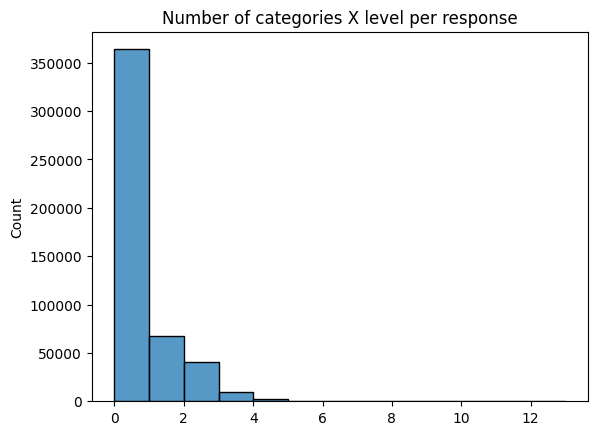

In [123]:
num_cat_levels = np.array([len(cats) for cats in found_cat_level])
sns.histplot(num_cat_levels, bins=max(num_cat_levels))
plt.title("Number of categories X level per response")
plt.show()